In [10]:
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data - FIXED QUERY
TRANSACTION_QUERY = """
WITH base AS (
  SELECT
    customer_id,
    case when market = 'us' then 'US'
    when market = 'uk' then 'UK'
    else 'EU' end as market,
    transaction_completed_datetime
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
),
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(transaction_completed_datetime ORDER BY transaction_completed_datetime) AS txns
  FROM base
  GROUP BY customer_id, market
)
SELECT
  customer_id,
  market,
  DATE(txns[OFFSET(0)]) AS first_txn_date,
  CASE 
    WHEN ARRAY_LENGTH(txns) >= 2 THEN
      DATE_DIFF(DATE(txns[OFFSET(1)]), DATE(txns[OFFSET(0)]), DAY)
    ELSE 0
  END AS days_between_first_and_second
FROM first_two;
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'first_txn_date': 'datetime64[ns]',
    'days_between_first_and_second': 'int32'
}

df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


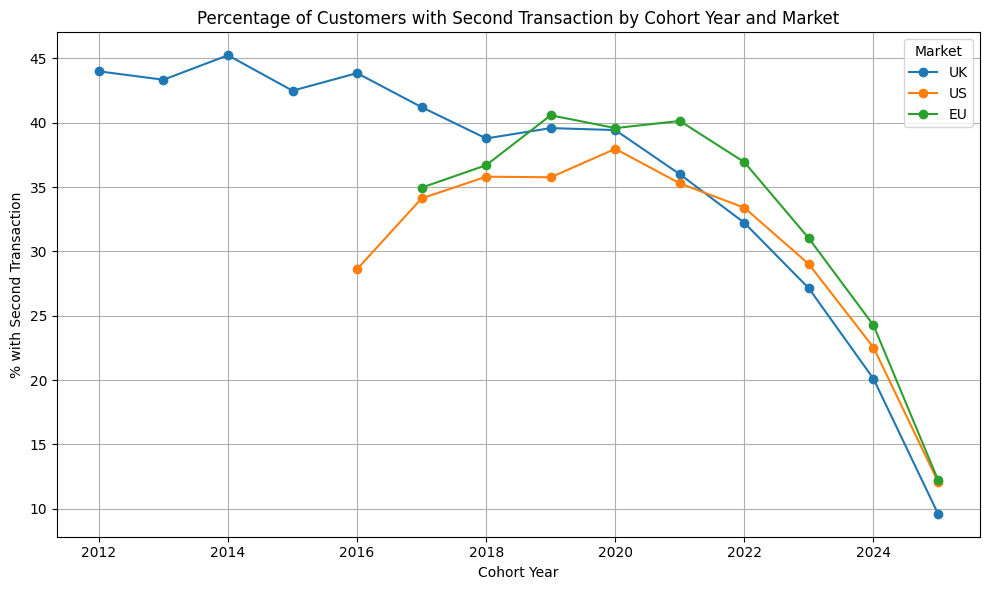

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract cohort year
df['cohort_year'] = pd.to_datetime(df['first_txn_date']).dt.year

# Flag customers with a second transaction
df['has_second_txn'] = df['days_between_first_and_second'] > 0

# Group by cohort year and market, calculate percentage
summary = (
    df.groupby(['cohort_year', 'market'])
      .agg(total_customers=('customer_id', 'count'),
           second_txn_customers=('has_second_txn', 'sum'))
      .reset_index()
)
summary['pct_with_second_txn'] = summary['second_txn_customers'] / summary['total_customers'] * 100

# Plot
plt.figure(figsize=(10,6))
for market in summary['market'].unique():
    market_data = summary[summary['market'] == market]
    plt.plot(market_data['cohort_year'], market_data['pct_with_second_txn'], marker='o', label=market)

plt.xlabel('Cohort Year')
plt.ylabel('% with Second Transaction')
plt.title('Percentage of Customers with Second Transaction by Cohort Year and Market')
plt.legend(title='Market')
plt.grid(True)
plt.tight_layout()
plt.show()

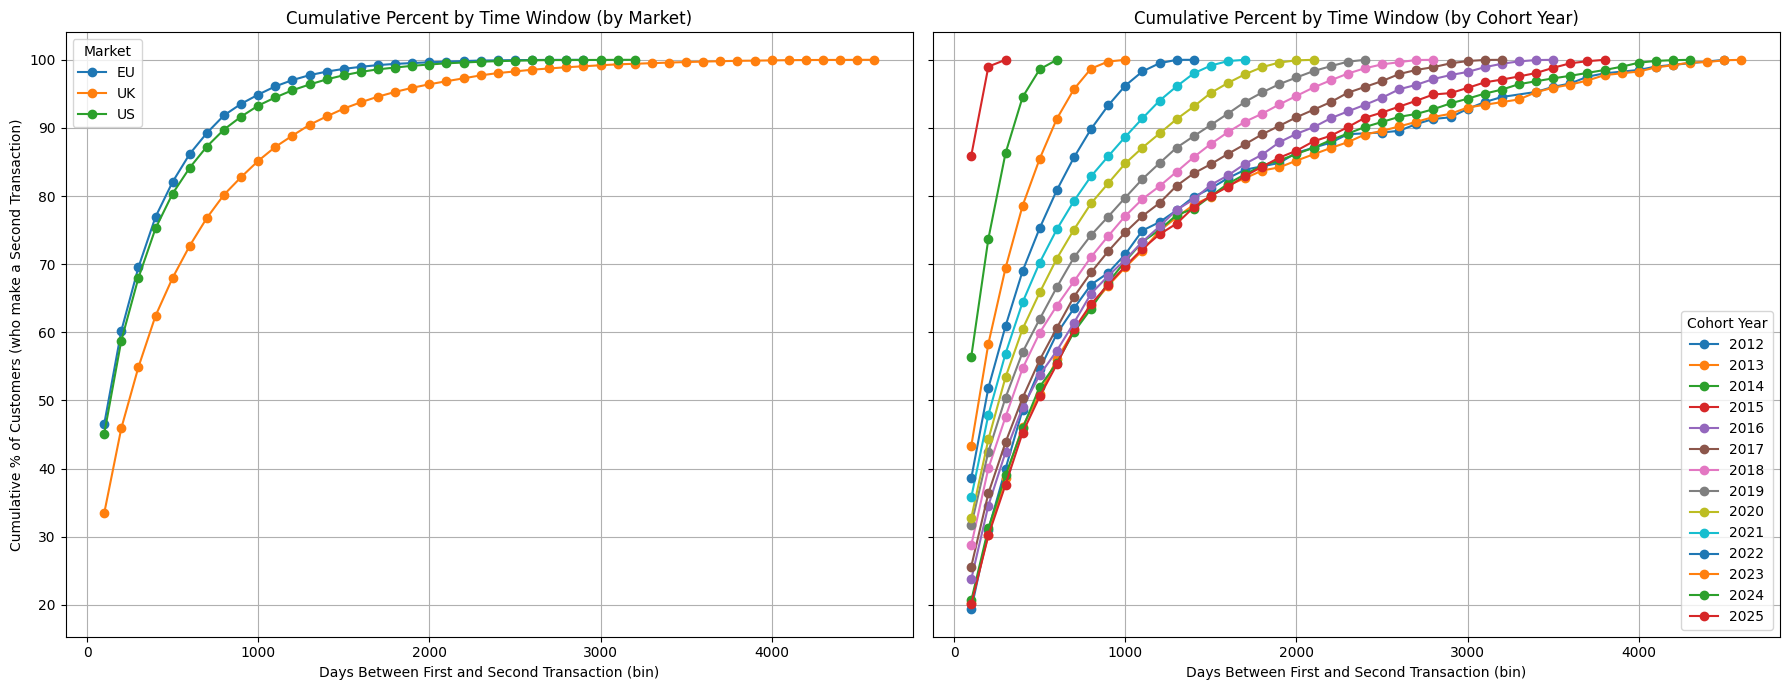

In [7]:
# Filter to only customers with a second transaction
df2 = df[df['days_between_first_and_second'] > 0].copy()

# Bin days into intervals of 100 days
bins = range(0, df2['days_between_first_and_second'].max() + 101, 100)
labels = bins[1:]
df2['days_bin'] = pd.cut(df2['days_between_first_and_second'], bins=bins, labels=labels, right=True)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# First plot: cumulative percent by market
for market in df2['market'].unique():
    data = df2[df2['market'] == market]
    total = len(data)
    # For each bin, cumulative count up to that bin
    cum_counts = data.groupby('days_bin', observed=True).size().cumsum()
    cum_pct = cum_counts / total * 100
    axes[0].plot(cum_pct.index.astype(int), cum_pct.values, marker='o', label=market)
axes[0].set_xlabel('Days Between First and Second Transaction (bin)')
axes[0].set_ylabel('Cumulative % of Customers (who make a Second Transaction)')
axes[0].set_title('Cumulative Percent by Time Window (by Market)')
axes[0].legend(title='Market')
axes[0].grid(True)

# Second plot: cumulative percent by cohort year
for year in sorted(df2['cohort_year'].unique()):
    data = df2[df2['cohort_year'] == year]
    total = len(data)
    cum_counts = data.groupby('days_bin', observed=True).size().cumsum()
    cum_pct = cum_counts / total * 100
    axes[1].plot(cum_pct.index.astype(int), cum_pct.values, marker='o', label=str(year))
axes[1].set_xlabel('Days Between First and Second Transaction (bin)')
axes[1].set_title('Cumulative Percent by Time Window (by Cohort Year)')
axes[1].legend(title='Cohort Year')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Manual Threshold Approach for Customer Lifecycle Classification
import pandas as pd
from datetime import datetime, timedelta

# Get all customer transaction data with last transaction date
CUSTOMER_STATUS_QUERY = """
WITH customer_txns AS (
  SELECT
    customer_id,
    case when market = 'us' then 'US'
    when market = 'uk' then 'UK'
    else 'EU' end as market,
    transaction_completed_datetime,
    COUNT(*) OVER (PARTITION BY customer_id) as total_txns
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_completed_datetime IS NOT NULL
),
customer_summary AS (
  SELECT
    customer_id,
    market,
    total_txns,
    MIN(DATE(transaction_completed_datetime)) AS first_txn_date,
    MAX(DATE(transaction_completed_datetime)) AS last_txn_date,
    DATE_DIFF(CURRENT_DATE(), MAX(DATE(transaction_completed_datetime)), DAY) AS days_since_last_txn
  FROM customer_txns
  GROUP BY customer_id, market, total_txns
)
SELECT *
FROM customer_summary
ORDER BY customer_id;
"""

# Get customer status data
customer_df = bq.to_dataframe(CUSTOMER_STATUS_QUERY, job_config=job_config)
print(f"Loaded {len(customer_df):,} customers")

# Define manual thresholds (in days)
ALIVE_THRESHOLD = 200      # Customer is "alive" if last transaction within 90 days
LAPSING_THRESHOLD = 540   # Customer is "lapsing" if last transaction between 90-180 days

def classify_customer_status(days_since_last, total_txns):
    """
    Classify customer based on days since last transaction
    """
    if days_since_last <= ALIVE_THRESHOLD:
        return 'alive'
    elif days_since_last <= LAPSING_THRESHOLD:
        return 'lapsing'
    else:
        return 'lapsed'

# Apply classification
customer_df['status'] = customer_df.apply(
    lambda row: classify_customer_status(row['days_since_last_txn'], row['total_txns']), 
    axis=1
)

# Summary by status
status_summary = customer_df['status'].value_counts().sort_index()
print("\nCustomer Status Distribution:")
print(status_summary)
print(f"\nPercentages:")
print((status_summary / len(customer_df) * 100).round(2))

Loaded 1,341,797 customers

Customer Status Distribution:
status
alive      260469
lapsed     791971
lapsing    289357
Name: count, dtype: int64

Percentages:
status
alive      19.41
lapsed     59.02
lapsing    21.56
Name: count, dtype: float64


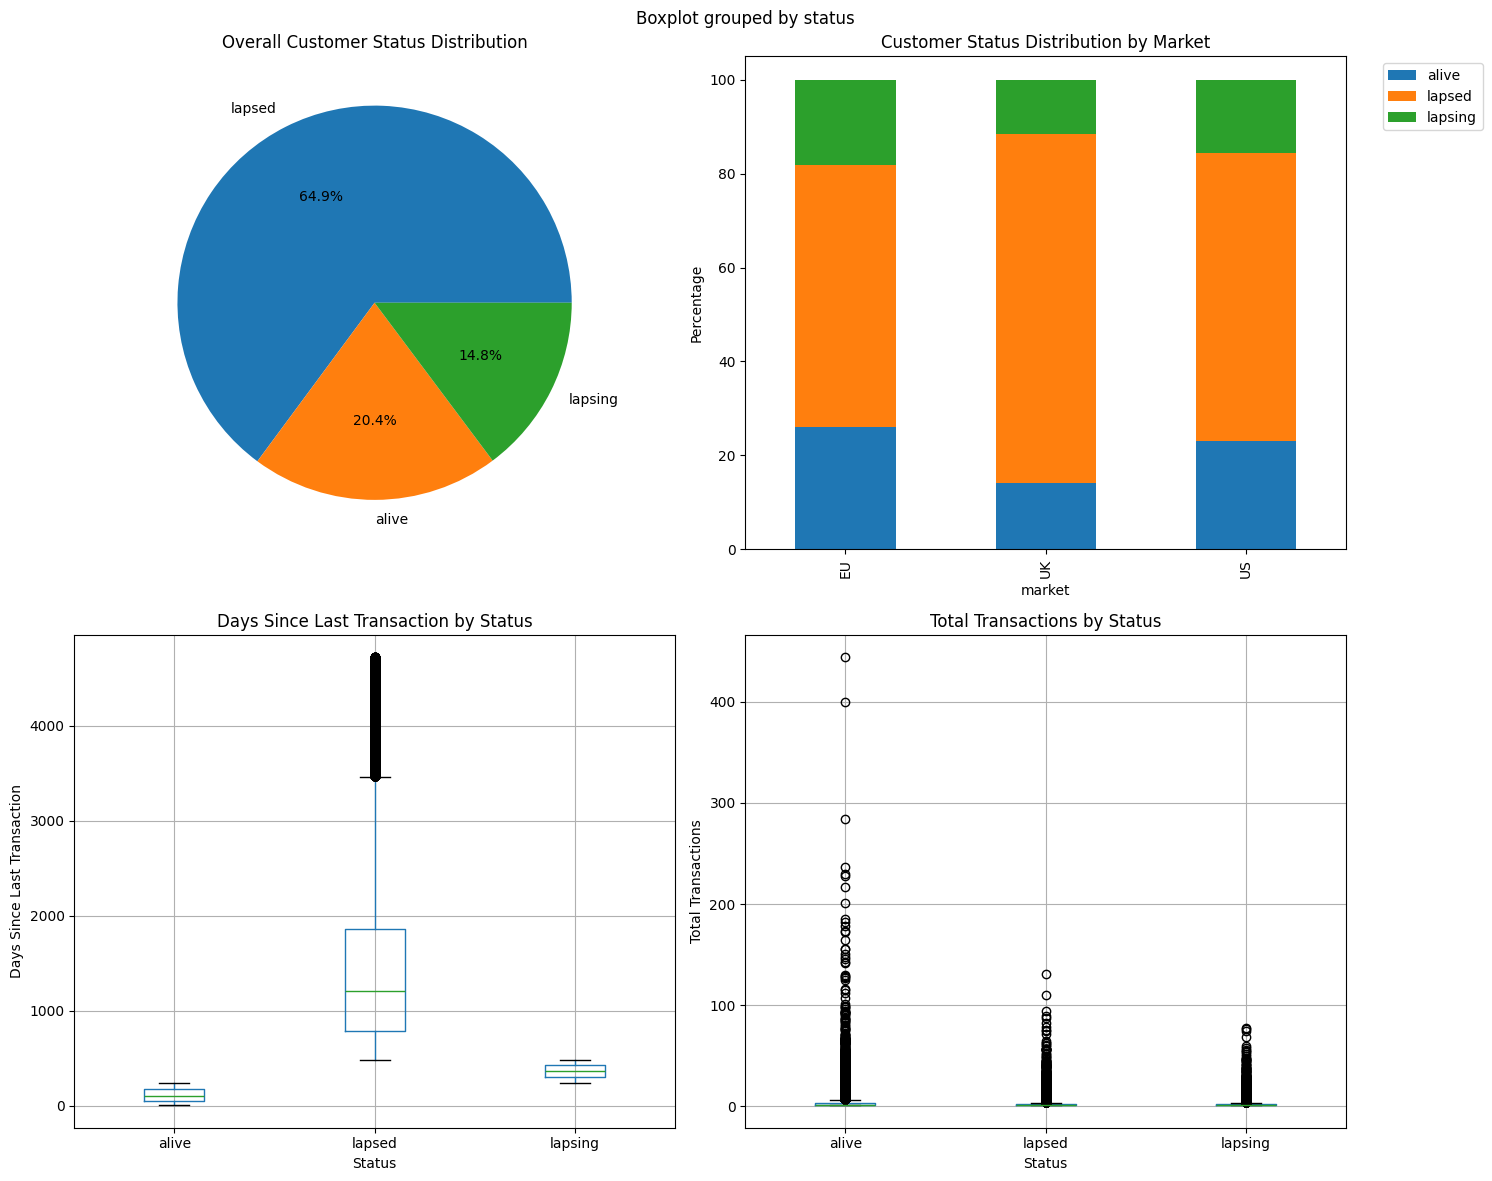


MARKET-SPECIFIC ANALYSIS

UK Market (144,061 customers):
  lapsed: 74.5%
  alive: 14.0%
  lapsing: 11.5%

EU Market (109,876 customers):
  lapsed: 55.7%
  alive: 26.0%
  lapsing: 18.3%

US Market (111,887 customers):
  lapsed: 61.4%
  alive: 23.0%
  lapsing: 15.6%

THRESHOLD SENSITIVITY ANALYSIS

Thresholds: Alive ≤ 60 days, Lapsing ≤ 120 days
  alive: 6.2%
  lapsed: 88.6%
  lapsing: 5.2%

Thresholds: Alive ≤ 90 days, Lapsing ≤ 180 days
  alive: 9.0%
  lapsed: 83.9%
  lapsing: 7.1%

Thresholds: Alive ≤ 120 days, Lapsing ≤ 240 days
  alive: 11.4%
  lapsed: 79.6%
  lapsing: 8.9%

Thresholds: Alive ≤ 240 days, Lapsing ≤ 480 days
  alive: 20.4%
  lapsed: 64.9%
  lapsing: 14.8%

Thresholds: Alive ≤ 330 days, Lapsing ≤ 1000 days
  alive: 25.8%
  lapsed: 39.4%
  lapsing: 34.8%

Thresholds: Alive ≤ 450 days, Lapsing ≤ 1400 days
  alive: 33.1%
  lapsed: 26.6%
  lapsing: 40.2%


In [13]:
# Visualize customer status distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall status distribution
status_counts = customer_df['status'].value_counts()
axes[0,0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Overall Customer Status Distribution')

# 2. Status by market
status_market = customer_df.groupby(['market', 'status']).size().unstack(fill_value=0)
status_market_pct = status_market.div(status_market.sum(axis=1), axis=0) * 100
status_market_pct.plot(kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Customer Status Distribution by Market')
axes[0,1].set_ylabel('Percentage')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Days since last transaction distribution by status
customer_df.boxplot(column='days_since_last_txn', by='status', ax=axes[1,0])
axes[1,0].set_title('Days Since Last Transaction by Status')
axes[1,0].set_xlabel('Status')
axes[1,0].set_ylabel('Days Since Last Transaction')

# 4. Total transactions distribution by status
customer_df.boxplot(column='total_txns', by='status', ax=axes[1,1])
axes[1,1].set_title('Total Transactions by Status')
axes[1,1].set_xlabel('Status') 
axes[1,1].set_ylabel('Total Transactions')

plt.tight_layout()
plt.show()

# Additional analysis: Market-specific breakdown
print("\n" + "="*60)
print("MARKET-SPECIFIC ANALYSIS")
print("="*60)

for market in customer_df['market'].unique():
    market_data = customer_df[customer_df['market'] == market]
    print(f"\n{market} Market ({len(market_data):,} customers):")
    market_status = market_data['status'].value_counts(normalize=True) * 100
    for status, pct in market_status.items():
        print(f"  {status}: {pct:.1f}%")

# Threshold sensitivity analysis
print("\n" + "="*60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)

def test_thresholds(alive_thresh, lapsing_thresh):
    """Test different threshold combinations"""
    test_df = customer_df.copy()
    
    def classify_test(days_since_last, total_txns):
        if days_since_last <= alive_thresh:
            return 'alive'
        elif days_since_last <= lapsing_thresh:
            return 'lapsing'
        else:
            return 'lapsed'
    
    test_df['test_status'] = test_df.apply(
        lambda row: classify_test(row['days_since_last_txn'], row['total_txns']), 
        axis=1
    )
    
    return test_df['test_status'].value_counts(normalize=True) * 100

# Test different threshold combinations
threshold_combinations = [
    (60, 120),   # More conservative
    (90, 180),   # Current
    (120, 240),  # More liberal
    (240, 480),  # Very liberal
    (330, 1000),
    (450, 1400)
]

for alive_t, lapsing_t in threshold_combinations:
    print(f"\nThresholds: Alive ≤ {alive_t} days, Lapsing ≤ {lapsing_t} days")
    results = test_thresholds(alive_t, lapsing_t)
    for status, pct in results.sort_index().items():
        print(f"  {status}: {pct:.1f}%")

In [11]:
# Analyze transaction timing patterns to set optimal thresholds
import numpy as np

print("="*70)
print("EMPIRICAL THRESHOLD ANALYSIS")
print("="*70)

# Use the original df with second transaction timing data
df_with_second = df[df['days_between_first_and_second'] > 0].copy()

print(f"\nCustomers with 2nd transaction: {len(df_with_second):,}")
print(f"Days between 1st and 2nd transaction - Key percentiles:")

percentiles = [50, 60, 70, 75, 80, 85, 90, 95, 99]
for p in percentiles:
    value = np.percentile(df_with_second['days_between_first_and_second'], p)
    print(f"  {p}th percentile: {value:.0f} days")

print(f"\n" + "="*50)
print("RECOMMENDED THRESHOLD SCENARIOS")
print("="*50)

# Scenario 1: Conservative (catch 75% of repeat customers)
thresh_75 = np.percentile(df_with_second['days_between_first_and_second'], 75)
print(f"\nSCENARIO 1 - Conservative (75th percentile)")
print(f"  Alive threshold: {thresh_75/3:.0f} days")
print(f"  Lapsing threshold: {thresh_75:.0f} days") 
print(f"  Rationale: Captures 75% of customers who do make a 2nd transaction")

# Scenario 2: Balanced (catch 85% of repeat customers)  
thresh_85 = np.percentile(df_with_second['days_between_first_and_second'], 85)
print(f"\nSCENARIO 2 - Balanced (85th percentile)")
print(f"  Alive threshold: {thresh_85/3:.0f} days")
print(f"  Lapsing threshold: {thresh_85:.0f} days")
print(f"  Rationale: Captures 85% of customers who do make a 2nd transaction")

# Scenario 3: Liberal (catch 90% of repeat customers)
thresh_90 = np.percentile(df_with_second['days_between_first_and_second'], 90) 
print(f"\nSCENARIO 3 - Liberal (90th percentile - your reference)")
print(f"  Alive threshold: {thresh_90/3:.0f} days")
print(f"  Lapsing threshold: {thresh_90:.0f} days")
print(f"  Rationale: Captures 90% of customers who do make a 2nd transaction")

# Scenario 4: Very Liberal (catch 95% of repeat customers)
thresh_95 = np.percentile(df_with_second['days_between_first_and_second'], 95)
print(f"\nSCENARIO 4 - Very Liberal (95th percentile)")
print(f"  Alive threshold: {thresh_95/3:.0f} days") 
print(f"  Lapsing threshold: {thresh_95:.0f} days")
print(f"  Rationale: Captures 95% of customers who do make a 2nd transaction")

print(f"\n" + "="*50)
print("BUSINESS CONSIDERATIONS")
print("="*50)
print("""
Key trade-offs:
• Conservative thresholds = Faster identification of lapsed customers, more aggressive intervention
• Liberal thresholds = Longer patience period, risk of late/ineffective intervention

Recommendation: Start with SCENARIO 2 (Balanced) as it captures 85% of repeat 
customers while still allowing reasonably timely intervention for truly lapsed customers.
""")

EMPIRICAL THRESHOLD ANALYSIS

Customers with 2nd transaction: 109,120
Days between 1st and 2nd transaction - Key percentiles:
  50th percentile: 168 days
  60th percentile: 266 days
  70th percentile: 397 days
  75th percentile: 489 days
  80th percentile: 603 days
  85th percentile: 754 days
  90th percentile: 985 days
  95th percentile: 1384 days
  99th percentile: 2353 days

RECOMMENDED THRESHOLD SCENARIOS

SCENARIO 1 - Conservative (75th percentile)
  Alive threshold: 163 days
  Lapsing threshold: 489 days
  Rationale: Captures 75% of customers who do make a 2nd transaction

SCENARIO 2 - Balanced (85th percentile)
  Alive threshold: 251 days
  Lapsing threshold: 754 days
  Rationale: Captures 85% of customers who do make a 2nd transaction

SCENARIO 3 - Liberal (90th percentile - your reference)
  Alive threshold: 328 days
  Lapsing threshold: 985 days
  Rationale: Captures 90% of customers who do make a 2nd transaction

SCENARIO 4 - Very Liberal (95th percentile)
  Alive threshold: